In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

## Green's Function

In [ ]:
G_ds_path = 'Outputs/G_pulse_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

In [28]:
G_ds = xr.open_dataset('Outputs/G_pulse_ds.nc4')['__xarray_dataarray_variable__']

G_CDR_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']

G_ds = xr.concat([G_ds, -G_CDR_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

## Convolution

In [29]:
conv_mean_ds = xr.open_dataset('Outputs/conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

## CMIP6 1pct

In [30]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

## Emissions profile

In [31]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')


# Settings and Define our Model Weights

In [32]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

In [33]:
type_color = utils.type_color

In [34]:
A = utils.A
ds_out = utils.ds_out

## Fourier Transform

In [35]:
from scipy.fft import fft, ifft

In [36]:
mean_G = G_ds.weighted(G_model_weights).mean(dim = ['model','pulse_type']).weighted(A).mean(dim = ['lat','lon'])

In [37]:
mean_emis = emis_profile.weighted(onepct_model_weights).mean(dim = 'model').sel(experiment = '1pct')

In [38]:
fg = fft(np.array(mean_G))
fe = fft(np.array(mean_emis['emis'].dropna('year')))

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


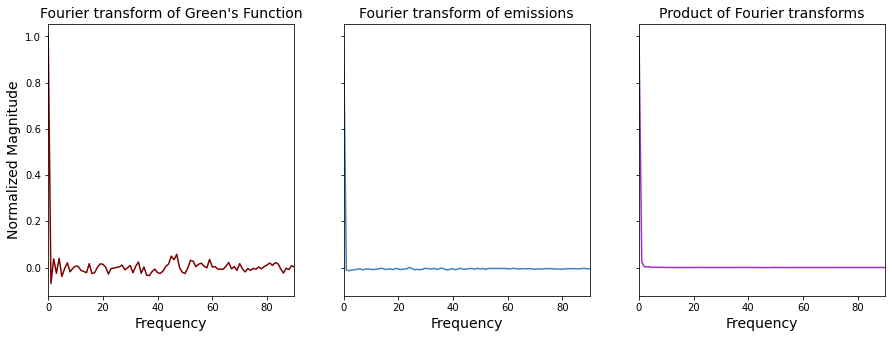

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = [15,5], sharex = True, sharey = True)

ax1.plot(fg/fg[0], color = 'maroon')
ax1.set_title('Fourier transform of Green\'s Function', fontsize = 14)

ax2.plot(fe/fe[0], color = 'steelblue')
ax2.set_title('Fourier transform of emissions', fontsize = 14)

ax3.plot((fg[:len(fe)]*fe)/(fg[:len(fe)]*fe)[0], color = 'darkorchid')
ax3.set_title('Product of Fourier transforms', fontsize = 14)

ax1.set_ylabel('Normalized Magnitude', fontsize = 14)
ax1.set_xlabel('Frequency', fontsize = 14)
ax2.set_xlabel('Frequency', fontsize = 14)
ax3.set_xlabel('Frequency', fontsize = 14)
plt.xlim(0,90)
plt.savefig('figures/paper/supp_fourier_transform.png', bbox_inches = 'tight', dpi = 350)